In [7]:
%matplotlib inline
import os
import sys
import glob
import math
import codecs
import warnings
import numpy as np
from scipy import stats
import nilearn.datasets
import nilearn.connectome
from sklearn.svm import SVC
from itertools import count
from functools import partial
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.manifold import TSNE
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from sklearn.cross_validation import KFold
from sklearn.covariance import GraphLassoCV
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from statsmodels.stats.multitest import multipletests
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,MultiComparison)

warnings.filterwarnings('ignore')

In [8]:
def apply_svd(X, dim):
    svd = TruncatedSVD(n_components=dim)
    svd.fit(X)
    Xdim = svd.transform(X)
    return Xdim

In [9]:
def parse_names(filenames):
  names = []
  for filename in filenames:
    name = filename.replace('/Users/admin/Documents/Stanford/Research/Neuro-Anesthesia/data/Stanford-Anesthesia/','')
    name = name.replace('/session_1/rest_1/rest.nii.gz','')
    name = name.replace('Exposed/','E_')
    name = name.replace('Control/', 'C_')
    names.append(name)

  return names

In [10]:
def dump_data(kind, ids, data):
  label_file = codecs.open(kind+'_labels.txt', "w", "utf-8")
  file = codecs.open(kind+'_embeddings.txt', "w", "utf-8")
  for id, vect in zip(ids, data):
    vect = map(str, vect.tolist())
    vect_str = id+' '+(' '.join(vect))+'\n'
    label_file.write(id+'\n')
    file.write(vect_str)
  file.close()
  label_file.close()
  return

In [11]:
def plot_decision_boundary(X, y, names, kind):

  label_to_number = defaultdict(partial(next, count(1)))
  ytmp = np.array(y)
  index_test = ytmp == 1
  index_control = ytmp == 0

  fig, ax = plt.subplots()

  ax_control = ax.scatter(X[index_control, 0], X[index_control, 1], c='blue', s=50*1*1, cmap=plt.cm.Spectral)
  ax_exposed = ax.scatter(X[index_test, 0], X[index_test, 1], c='red', s=50*2*2, cmap=plt.cm.Spectral)
  #names =[]
  
  for label, x, y in zip(names, X[:, 0], X[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.1),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
  
  plt.legend((ax_control, ax_exposed),('Control', 'Exposed'), loc=0, scatterpoints = 1)
  plt.suptitle(kind + " plot")
  plt.savefig(kind+'_anesthesia_visualization.png')   # save the figure to file

In [12]:
def read_dataset():
    atlas = nilearn.datasets.fetch_atlas_msdl()

    test_subject_path = '/Users/admin/Documents/Stanford/Research/Neuro-Anesthesia/data/Stanford-Anesthesia/Exposed/'
    control_subject_path = '/Users/admin/Documents/Stanford/Research/Neuro-Anesthesia/data/Stanford-Anesthesia/Control/'

    test_subjects_resting_files = glob.glob(test_subject_path+ '*/session_1/rest_1/*.gz')
    test_subject_labels = np.ones(len(test_subjects_resting_files))

    control_subjects_resting_files = glob.glob(control_subject_path+ '*/session_1/rest_1/*.gz')
    control_subject_labels = np.zeros(len(control_subjects_resting_files))

    test_ids = parse_names(test_subjects_resting_files)
    control_ids = parse_names(control_subjects_resting_files)

    test_subjects_names = ['E'+str(directories+1) for directories in range(12)]
    control_subjects_names = ['C'+str(directories+1) for directories in range(12)]

    resting_files = test_subjects_resting_files + control_subjects_resting_files
    labels = np.concatenate((test_subject_labels, control_subject_labels), axis=0)
    names = np.concatenate((test_subjects_names, control_subjects_names), axis=0)
    ids = np.concatenate((test_ids, control_ids), axis=0)

    return atlas, resting_files, labels, names, ids

In [13]:
def extract_time_series(resting_files, labels, atlas):
    ######################################################################
    # Extract regions time series signals
    import nilearn.input_data
    masker = nilearn.input_data.NiftiMapsMasker(
        atlas.maps, resampling_target="maps", detrend=True,
        low_pass=None, high_pass=None, t_r=2.5, standardize=False,
        memory='nilearn_cache', memory_level=1)
    subjects = []
    for func_file, phenotypic in zip(resting_files, labels):
        time_series = masker.fit_transform(func_file)
        subjects.append(time_series)
    
    return subjects

In [14]:
def calculate_functional_connectivity_matrices(subjects, kind):
    
    individual_connectivity_matrices = {}
    conn_measure = nilearn.connectome.ConnectivityMeasure(kind=kind)

    individual_connectivity_matrices = conn_measure.fit_transform(subjects)

    # Compute the mean connectivity
    if kind == 'tangent':
        mean_connectivity_matrices = conn_measure.mean_
    else:
        mean_connectivity_matrices = \
            individual_connectivity_matrices.mean(axis=0)
    
    return individual_connectivity_matrices, mean_connectivity_matrices

In [15]:
def get_atlas_labels(atlas):
    atlas_labels = []

    for label in atlas.labels:
      atlas_labels.append(label.decode('UTF-8'))
    return atlas_labels

In [16]:
def split_connectivity_matrices(individual_connectivity_matrices, labels):
    test_subjects_indices = [i for i in range(len(labels)) if labels[i] == 1]
    control_subjects_indices = [i for i in range(len(labels)) if labels[i] == 0]

    test_subjects_matrices = individual_connectivity_matrices[test_subjects_indices,:,:]
    control_subjects_matrices = individual_connectivity_matrices[control_subjects_indices,:,:]
    
    return test_subjects_matrices, control_subjects_matrices

In [17]:
def select_features(control_subjects_matrices, test_subjects_matrices, individual_connectivity_matrices, atlas):
    t_mat, prob_mat = stats.ttest_ind(control_subjects_matrices, test_subjects_matrices, equal_var=False)
    
    t_test_rejection_threshold = 0.05
    
    reject_indexes_mat = np.argwhere(prob_mat < t_test_rejection_threshold)
    
    if reject_indexes_mat.shape[0] == 0:
        print('no significant change in any region pairs')
        sys.exit(-1)
    
    reject_indexes_mat = np.squeeze(reject_indexes_mat)
    
    selected_feature_set = np.zeros(shape=individual_connectivity_matrices.shape, dtype=individual_connectivity_matrices.dtype)
    for x, y in reject_indexes_mat:
        if x >= y: # ignore lower triangular part of the matrix
            continue
        selected_feature_set[:, x,y] = individual_connectivity_matrices[:, x, y]
    
    return selected_feature_set, t_mat, prob_mat, reject_indexes_mat

In [18]:
def print_and_plot_selected_features(selected_feature_set, reject_indexes_mat, t_mat, prob_mat, labels, atlas, names, kind):
    
    reject_indexes_mat_labels = [((atlas.labels[ind[0]], atlas.labels[ind[1]]),(t_mat[ind[0],ind[1]], prob_mat[ind[0],ind[1]]))  for ind in reject_indexes_mat if ind[0] < ind[1]]
    
    
    print ('------- Selected region pairs in Latex format --------')
    for (region1, region2), (t,p) in reject_indexes_mat_labels:
        print(region1.decode('utf-8') + ' & ' + region2.decode('utf-8') +' & ' + str(round(t, 3)) + ' & ' + str(round(p,3)) + ' \\\\')
    
    
    prob_mat_plot = prob_mat
    
    prob_mat_plot[:] = 0
        
    for ind in reject_indexes_mat:
        prob_mat_plot[ind[0], ind[1]] = 1
    
    atlas_labels = get_atlas_labels (atlas)
    
    print ('------- Selected region pairs in matrix format --------')
    
    plt.figure(figsize=(10, 10))
    # Mask out the major diagonal
    np.fill_diagonal(prob_mat_plot, 0)
    plt.imshow(prob_mat_plot, interpolation="nearest", cmap="Reds",vmax=1, vmin=0)
    plt.colorbar()
    # And display the labels
    x_ticks = plt.xticks(range(len(atlas.labels)), atlas_labels, rotation=90)
    y_ticks = plt.yticks(range(len(atlas.labels)), atlas_labels)
    plt.show()
    
    x2 = apply_svd(selected_feature_set, 2)
    x1 = TSNE(n_components=2, verbose=0).fit_transform(selected_feature_set)
    plot_decision_boundary(x2, labels, names, kind)

In [19]:
def classify(selected_feature_set, labels):
    
    #Experiment different size of k-fold methods
    n_folds=12
    cv = StratifiedKFold(labels, n_folds=n_folds)
    #cv = KFold(n=24, n_folds=n_folds, shuffle=True)
    
    #Experiment different SVM kernels
    C=1
    svc = SVC(kernel='rbf',C=C)
    #svc = LinearSVC()
    
    print ('------- Classification results  --------')
    print('C:', C)
    print('Number of folds:', n_folds)
    cv_scores = cross_val_score(svc, selected_feature_set, labels, cv=cv, scoring='accuracy')
    print('Mean score: %1.2f +- %1.2f' % (cv_scores.mean(), cv_scores.std()))
    print('Cross validation scores:', cv_scores)


In [20]:
def analyze_functional_connectivity(kind):
    
    print ('************* ' + kind + ' analysis *************')
    atlas, resting_files, labels, names, ids = read_dataset()
    
    subjects = extract_time_series(resting_files, labels, atlas)
    
    individual_connectivity_matrices, mean_connectivity_matrices = calculate_functional_connectivity_matrices (subjects, kind)
    
    test_subjects_matrices, control_subjects_matrices = split_connectivity_matrices(individual_connectivity_matrices, labels)
    
    selected_feature_set, t_mat, prob_mat, reject_indexes_mat = select_features(control_subjects_matrices, test_subjects_matrices, individual_connectivity_matrices, atlas)
    
    selected_feature_set = selected_feature_set.reshape(24, -1)
    
    print_and_plot_selected_features(selected_feature_set, reject_indexes_mat, t_mat, prob_mat, labels, atlas, names, kind)
    
    classify(selected_feature_set, labels)
    

************* partial correlation analysis *************
------- Selected region pairs in Latex format --------
L Aud & Basal & -2.398 & 0.028 \\
L Aud & R A Ins & 2.282 & 0.035 \\
R Aud & L STS & 3.213 & 0.005 \\
R Aud & R STS & 2.225 & 0.038 \\
Striate & Front DMN & -2.132 & 0.048 \\
Striate & L Front pol & 3.533 & 0.002 \\
Striate & D ACC & -2.364 & 0.028 \\
L DMN & Cing & -3.223 & 0.004 \\
Med DMN & R Pars Op & -2.409 & 0.026 \\
Front DMN & Occ post & 2.381 & 0.027 \\
R DMN & R Ant IPS & 2.861 & 0.01 \\
Occ post & L Front pol & -3.391 & 0.003 \\
Motor & Cereb & 2.67 & 0.019 \\
R Par & L IPS & 2.232 & 0.038 \\
R Par & D ACC & -2.432 & 0.024 \\
Basal & L DLPFC & -2.753 & 0.012 \\
Basal & Vis & -2.233 & 0.039 \\
Basal & Broca & 2.372 & 0.028 \\
Basal & R Ins & 2.134 & 0.045 \\
Basal & R Ant IPS & -2.92 & 0.009 \\
L Par & D ACC & -2.213 & 0.038 \\
L DLPFC & R IPS & 2.138 & 0.045 \\
L DLPFC & R A Ins & 2.473 & 0.024 \\
L IPS & Dors PCC & 2.684 & 0.015 \\
L IPS & R Ins & 2.499 & 0.024 \\

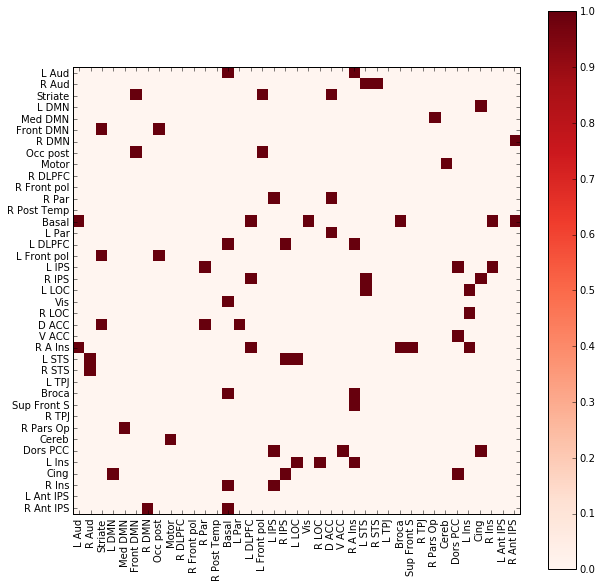

------- Classification results  --------
C: 1
Number of folds: 12
Mean score: 0.92 +- 0.19
Cross validation scores: [ 1.   1.   1.   1.   1.   0.5  0.5  1.   1.   1.   1.   1. ]


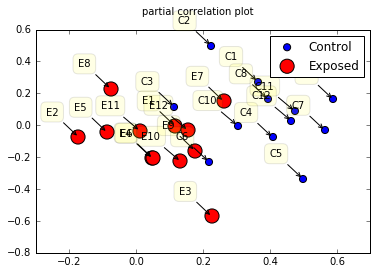

In [21]:
analyze_functional_connectivity('partial correlation')

************* correlation analysis *************
------- Selected region pairs in Latex format --------
L Aud & Motor & -2.081 & 0.05 \\
L Aud & Sup Front S & -2.611 & 0.016 \\
R Aud & R Ant IPS & -2.174 & 0.041 \\
Striate & R LOC & 2.101 & 0.047 \\
Striate & Sup Front S & -2.359 & 0.029 \\
Striate & L Ins & -2.569 & 0.019 \\
Striate & R Ins & -2.822 & 0.01 \\
L DMN & L Ins & 2.505 & 0.02 \\
L DMN & R Ins & 2.96 & 0.007 \\
R DMN & Cereb & -2.229 & 0.037 \\
Occ post & Sup Front S & 2.333 & 0.031 \\
Occ post & L Ins & 2.621 & 0.017 \\
Occ post & R Ins & 2.749 & 0.012 \\
Motor & R DLPFC & -2.166 & 0.041 \\
Motor & R Post Temp & 3.083 & 0.006 \\
Motor & L DLPFC & -2.555 & 0.018 \\
R DLPFC & Sup Front S & -2.843 & 0.01 \\
R DLPFC & L Ins & -2.131 & 0.045 \\
R Front pol & L TPJ & -2.245 & 0.042 \\
R Post Temp & L Front pol & 3.228 & 0.004 \\
R Post Temp & Sup Front S & 2.602 & 0.017 \\
R Post Temp & R Pars Op & 3.415 & 0.002 \\
R Post Temp & Cereb & 2.127 & 0.049 \\
Basal & R A Ins & -2.167 

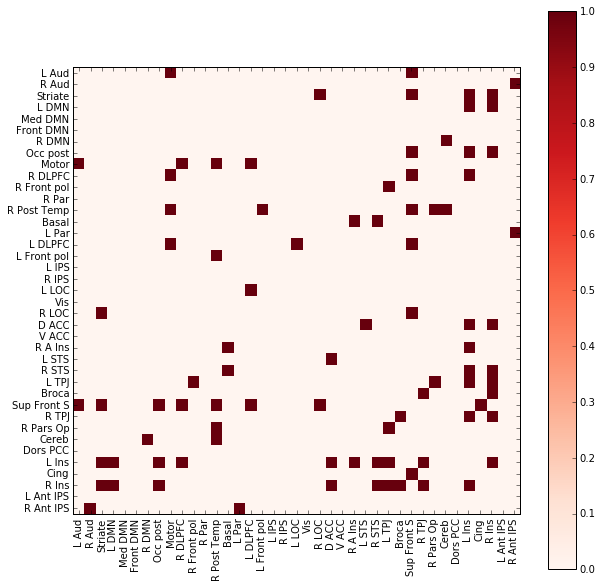

------- Classification results  --------
C: 1
Number of folds: 12
Mean score: 0.83 +- 0.24
Cross validation scores: [ 1.   1.   1.   0.5  0.5  1.   0.5  0.5  1.   1.   1.   1. ]


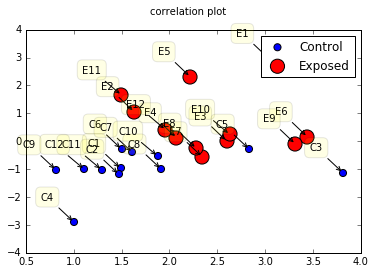

In [22]:
analyze_functional_connectivity('correlation')

************* covariance analysis *************
------- Selected region pairs in Latex format --------
L Aud & L Front pol & -2.271 & 0.036 \\
R Aud & L Front pol & -2.191 & 0.044 \\
Striate & L Ins & -2.399 & 0.032 \\
Occ post & L Ins & 2.512 & 0.026 \\
Motor & R A Ins & -2.221 & 0.047 \\
R DLPFC & Basal & -2.258 & 0.044 \\
R DLPFC & L Front pol & -2.255 & 0.042 \\
R DLPFC & L Ins & -2.22 & 0.048 \\
R Post Temp & L Front pol & 2.789 & 0.011 \\
R Post Temp & R Pars Op & 2.383 & 0.03 \\
R Post Temp & Cereb & 2.633 & 0.017 \\
Basal & R IPS & -2.227 & 0.046 \\
Basal & R STS & -2.697 & 0.02 \\
L DLPFC & L Front pol & -2.627 & 0.017 \\
L Front pol & Cing & -2.293 & 0.032 \\
D ACC & Sup Front S & -2.225 & 0.045 \\
R A Ins & Sup Front S & -2.249 & 0.043 \\
R A Ins & L Ins & -2.295 & 0.034 \\
R STS & L Ins & -2.253 & 0.041 \\
R STS & R Ins & -2.429 & 0.033 \\
------- Selected region pairs in matrix format --------


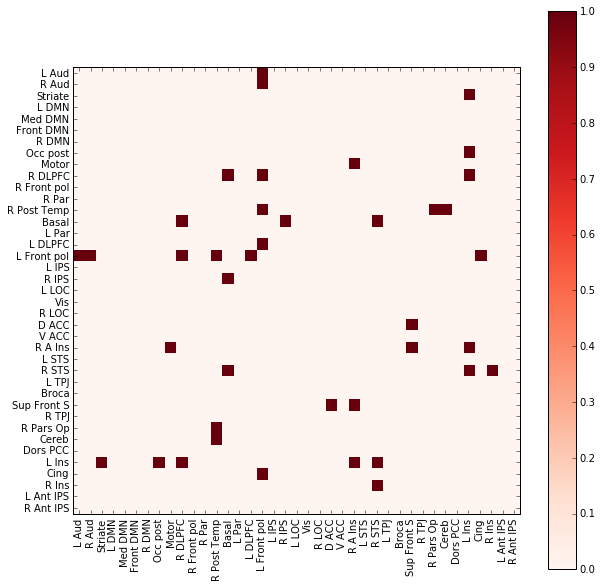

------- Classification results  --------
C: 1
Number of folds: 12
Mean score: 0.50 +- 0.00
Cross validation scores: [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]


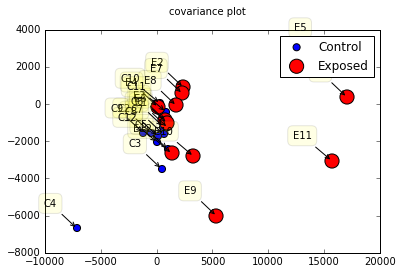

In [23]:
analyze_functional_connectivity('covariance')

************* precision analysis *************
------- Selected region pairs in Latex format --------
L Aud & Front DMN & 2.161 & 0.047 \\
L Aud & Basal & 2.474 & 0.023 \\
R Aud & R Pars Op & -2.175 & 0.049 \\
L DMN & Cing & 2.578 & 0.025 \\
Med DMN & L Ant IPS & -2.422 & 0.024 \\
Front DMN & Occ post & -2.474 & 0.027 \\
Motor & L Par & -2.477 & 0.021 \\
Motor & L Ins & 2.23 & 0.038 \\
Basal & L DLPFC & 2.985 & 0.007 \\
Basal & Broca & -2.208 & 0.041 \\
Basal & R Ant IPS & 2.365 & 0.027 \\
R A Ins & Sup Front S & 2.278 & 0.038 \\
R A Ins & L Ins & 2.148 & 0.049 \\
L TPJ & Dors PCC & -2.157 & 0.046 \\
R TPJ & Cing & -2.544 & 0.023 \\
------- Selected region pairs in matrix format --------


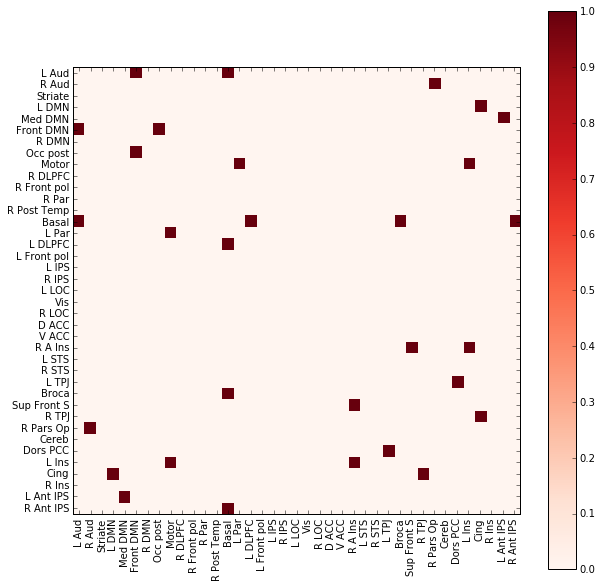

------- Classification results  --------
C: 1
Number of folds: 12
Mean score: 0.62 +- 0.22
Cross validation scores: [ 0.5  0.5  1.   1.   0.5  1.   0.5  0.5  0.5  0.5  0.5  0.5]


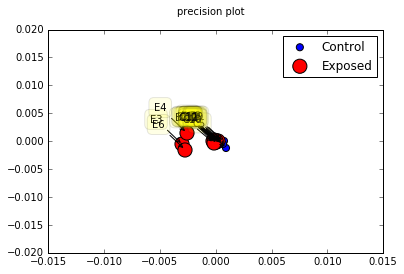

In [24]:
analyze_functional_connectivity('precision')

************* tangent analysis *************
------- Selected region pairs in Latex format --------
L Aud & Basal & -3.047 & 0.006 \\
R Aud & L STS & 3.921 & 0.001 \\
R Aud & R STS & 2.123 & 0.046 \\
L DMN & Cing & -2.564 & 0.018 \\
Front DMN & Occ post & 2.501 & 0.022 \\
R DMN & R Front pol & 2.603 & 0.016 \\
R DMN & R Ant IPS & 2.784 & 0.013 \\
Occ post & Motor & 2.143 & 0.045 \\
Motor & Cereb & 2.24 & 0.044 \\
R DLPFC & D ACC & -2.155 & 0.045 \\
R Par & L IPS & 2.123 & 0.047 \\
R Par & V ACC & 2.201 & 0.039 \\
Basal & L DLPFC & -2.551 & 0.018 \\
Basal & L Front pol & 2.478 & 0.022 \\
Basal & Vis & -2.911 & 0.009 \\
Basal & Broca & 2.222 & 0.037 \\
Basal & R Ant IPS & -3.124 & 0.005 \\
L Par & V ACC & 2.104 & 0.047 \\
L Par & R Ant IPS & 2.241 & 0.037 \\
L DLPFC & L Front pol & -2.402 & 0.028 \\
L DLPFC & Sup Front S & -2.848 & 0.012 \\
L DLPFC & L Ins & -2.926 & 0.008 \\
L Front pol & Cereb & 2.12 & 0.046 \\
L Front pol & Cing & -2.258 & 0.035 \\
L IPS & Dors PCC & 2.607 & 0.016 \\


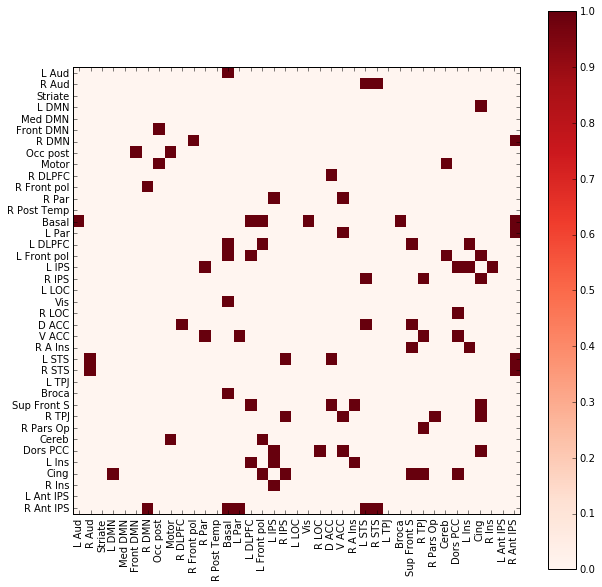

------- Classification results  --------
C: 1
Number of folds: 12
Mean score: 0.88 +- 0.22
Cross validation scores: [ 1.   1.   1.   1.   1.   0.5  0.5  0.5  1.   1.   1.   1. ]


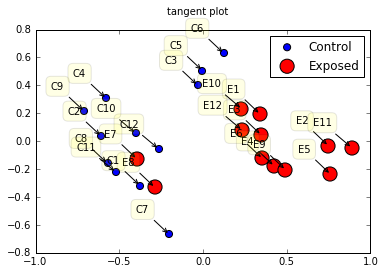

In [25]:
analyze_functional_connectivity('tangent')